# Day2　NumPyを扱うコツ
テトリスは、7種類のブロック (「ミノ」と呼びます) + ブロックの置かれていない状態の計8種類のマスを、高さ22段×横10列の盤面に並べている、と言えます。
そしてソースコードでは、置かれていない状態を「0」、I字型のミノを「1」、L字型のミノを「2」・・・とした、「0」から「7」までの数字が220個並んだものによって表現されています。<br><br>

この数字の並びを「配列」と呼びます。配列はその値を読み書きしたり、値を使って計算したりできます。ここでは、数学パズルのような問題を解いていくことを通じて、テトリスのソースコードに登場する配列の操作を学びます。
- リスト・配列・NumPy配列の違い
- サイズ (reshape)
- 演算 (sum・mean・max・min)

## 1. おまじない
前回のタートルグラフィックスと同様に、NumPyの機能を使えるようにするには`import`をします。このおまじないの後ろに`as`をつけて好きな文字列 (この場合は`np`)を書くと、`turtle.`や`numpy.`と書く必要があるところを、`np.`のように別の名前を付けてあげることができます。NumPyの場合は、その大文字を取って略されることが慣例です。

In [1]:
import numpy as np

それから、今回解いていただく問題の条件設定を視覚的に分かりやすく表現するための関数`drawArray`を定義しておきます。<span style="color: red; ">**関数の中身は本筋と関係ないので、読み飛ばして実行だけしてください**</span> (もちろんPythonに慣れていて興味のある方は、読んでも構いませんよ)。

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

colors = [[0,255,0],
          [255,0,0],
          [0,0,0]]


def drawArray(a,size = 20):
    if a.ndim == 1:
        a = a.reshape( (1, a.shape[0]) )
    
    block_array = []
    fig, ax = plt.subplots()
    size = max(size/a.shape[0], a.shape[0]/size)
    fig.set_figwidth(a.shape[0] * size)
    fig.set_figheight(a.shape[1] * size)

    for i in range(a.shape[0]):
        row = []
        for j in range(a.shape[1]):
            c = colors[int(a[i][j])]
            row.append(c)
        block_array.append(row)
    block_array = np.array(block_array)
    im = plt.imshow(block_array)

    ax.set_xticks(np.arange(-0.5, a.shape[1], 1.0), minor=True)
    ax.set_yticks(np.arange(-0.5, a.shape[0], 1.0), minor=True)
    ax.set_xticks(np.arange(-0.5, a.shape[1], 10))
    ax.set_yticks(np.arange(-0.5, a.shape[0], 3))
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax.imshow(block_array)


- - -

## 2. 問題「隣り合わないのがマナー？」
電車などで、空いている座席に座ることを考えます。一種のマナーなのか、自然と隣が空いている座席を選ぶことが多いようです。今回の問題でも、1列の座席で、他人と隣り合わずに座れる場合は他人の隣に座らないことにします。隣り合わないと座れない場合は、空いているところに座っていきます。<br><br>

6人が座れるロングシートが向かい合った電車を考えます (横浜線や京阪の各駅停車を想像してください)。計12席がある車両に12人が乗ってくる場合、12人の座る順番が何通りあるかを、プログラミングでパソコンに計算させてみましょう（座席はすべて区別でき、それぞれの座席には1人ずつ座るものとします）。

- - - 

## 3. 穴埋めをしながらプログラムを完成させよう
穴埋めをしていただきたい不完全な箇所には、前回と同様に<br>
`#------------ここから--------------`<br>
<br>
`#------------ここまで--------------`<br>
を記載しています。<br><br>

### 座席をプログラミングで表現するには？
テトリスのソースコードがミノの置かれていない状態を「0」、I字型のミノが存在する状態を「1」と数字を用いて表していたように、電車の座席も数字の並びとして表すことからスタートします。<br><br>

当たり前ではありますが、問題文より電車の座席には

- 空いている
- 誰か座っている

という2つの状態があります。ここでは、空いている状態を「0」、誰か座っている状態を「1」としましょう。もちろんこの数字は好きな値でも構わないのですが、NumPyに用意されている機能を考慮すると、0や1であると扱いやすいです。ここでは変数に予め値を代入しておきます。

In [3]:
FREE = 0
USED = 1

さて座席はすべて区別できると問題文に指定があるので、新幹線や特急列車のように各座席に番号を割り当てて状態を記録することにしましょう。ここでPythonでプログラミングをする場合には、ひと工夫を施してあげると非常にコードがスッキリします。<br><br>

まず、<b>Pythonの配列では番号は0から</b>始まる仕様があります。座席番号も「1番座席、2番座席、・・・、12番座席」と割り当てるのが直感的ではありますが、Pythonの仕様に合わせて「0番座席、1番座席、・・・、11番座席」と改番してあげる必要があります。Pythonでは「1番座席」は最も端の座席ではなく、その1つ隣の座席を表すのです。<br><br>

そして、問題文には「ロングシートが向かい合った」と記載がありますが、別に<b>座席が一列に並んでいても同じこと</b>であると言えると思います。ただし12人掛けのロングシートではなく、2つのロングシートの両端は1人だけしか隣に座りません。埋まってはいるけれども隣に座っても構わない、壁のようなものが両端の人の隣にあるとイメージしてください (実際の電車でも、ロングシートの両端には仕切り板が付いていますよね。よくドア横の人が寄りかかっているやつ)。
<br><br>
`
| ◯ ◯ ◯ ◯ ◯ ◯ |
`
<br>
`
ここは人が立つ通路      
`
<br>
`
| ◯ ◯ ◯ ◯ ◯ ◯ |
`
<br><br>
↓座席を横に繋げる↓
<br><br>
`
| ◯ ◯ ◯ ◯ ◯ ◯ || ◯ ◯ ◯ ◯ ◯ ◯ |
`
<br><br>
つまり6人掛けのロングシートを2つ横並びしたときに、壁同士が隣り合っている箇所を1つの壁と見なしてカウントすれば、「0番<b>壁</b>、1番座席、2番座席、・・・、6番座席、7番<b>壁</b>、8番座席、・・・13番座席、14番<b>壁</b>」という座席番号を割り振っても良い、と言えます。なぜならば座席は12個あるし、ロングシートの人が片一方側は壁だから気にしなくて良いことを再現できているからです。<br><br>

壁という、埋まってはいるけれども隣に座っても構わない状態を増やしたので、上と同様に変数を増やしておきます。因みに、こうして実際に扱いたい状態以外に追加した値のことを、「番兵」または「パディング」と呼びます。特に後者はAIの分野でよく登場する言葉です。

In [4]:
WALL = 2

いよいよ、座れる座席12個と壁3ヶ所の、計15個の数字の並びを作りましょう。電車の座席ははじめ誰も座っていないので、0がたくさん並んだ配列を作りましょう。ここでは、いったん15個の`FREE`が並ぶ配列を作ってから壁の位置だけ`WALL`に置き換えてあげる、という2ステップの操作を行ってみることにします。<br><br>

NumPyには、並べたい0の個数を指定できる`zeros()`という機能 (関数)が備わっています。タートルグラフィックスで言うところの、`forward()`や`right()`と同じ使い方をします。`seat`という変数に`zeros()`という関数を使って、0が15個並んだ配列を作成してください。

In [5]:
#------------ここから--------------
seat = np.zeros(15)
#------------ここまで--------------

試しにこの配列`seat`を、`print`文と上で定義した関数`drawArray`で表示してみましょう。関数`drawArray`は、座席が`FREE`のとき緑・`USED`のとき赤・`WALL`のとき黒で、それぞれ教えてくれます。<br><br>

こうして配列として並ばせた数字のことを、配列の「要素」と呼びます。今回のように要素数が15だけであれば目視で数えることができますが、もっと大きなサイズの配列になると`print`文で配列の全体を確認することが困難になります。そこで、NumPyの配列は`size`によって調べることのできる要素数という「属性」を持っています。変数`seat`の`size`を保存した変数`SeatSize`を`print`するコードを完成させてください。以下を実行し、<br>
`[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]`<br>
`15`<br>
と表示されれば成功です。

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15


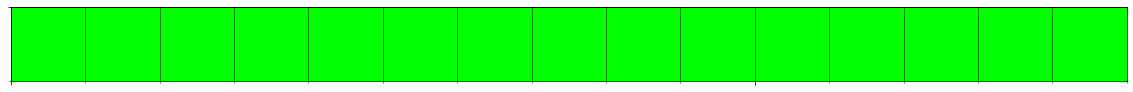

In [6]:
print(seat)
#------------ここから--------------
SeatSize = seat.size
#------------ここまで--------------
print(SeatSize)
drawArray(seat)

この配列は、「0番<b>壁</b>、1番座席、2番座席、・・・、6番座席、7番<b>壁</b>、8番座席、・・・13番座席、14番<b>壁</b>」という座席番号を割り当てたものでした。最後に、壁という扱いをした

- 0番目
- 7番目
- 14番目

の要素を、`WALL`に置き換えましょう。配列`seat`全体ではなく、ある要素の値に着目したいときには、`seat[要素番号]`という書き方をします。着目したい要素が複数ある場合、`[]`の中に`,`区切りで数字を列挙したもの (Pythonの文法用語で「list」型と呼ばれる書き方です)を書きます。

In [7]:
#------------ここから--------------
seat[[0, 7, 14]] = WALL
#------------ここまで--------------

念のため、もう一度配列を`print`文と関数`drawArray`で表示してみましょう。たしかに以下のように、0・7・14番目 (直感的に数えれば左から1・8・15番目)の値が<br>
`[2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2.]`<br>
と2に変わったことが分かると思います。

[2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2.]


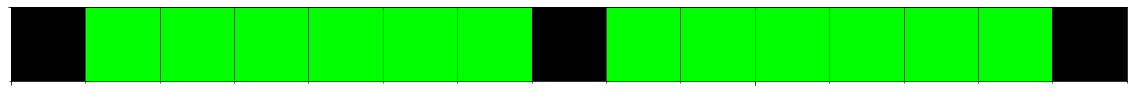

In [8]:
print(seat)
drawArray(seat)

### どうやって座れる場所を選ぶか？
用意した配列`seat`とその要素数`SeatSize`を使って、もし誰かと隣り合わせで座らなくて済む座席があればそこに座り、無ければ仕方なく空いている座席に詰めて座るアルゴリズムを作りましょう。ただし、Day2時点ではアルゴリズムのイメージだけを説明しますので、NumPy配列`seat`を操作したり、その要素で計算したりする箇所の実装にフォーカスいただきます。<br><br>

アルゴリズムのイメージを説明するために、間に壁を挟んだ要素数が15の配列ではなくもっと単純化して、3人がけの座席を考えてみましょう (車両の端にある優先席を思い浮かべてください)。すなわち、両端に壁があると見なした要素数5の配列を扱うことになります。<br><br>

3人がけの座席が全て空いているとき、乗客の1人目が座れる座席は当然、左端 (1番座席)・中央 (2番座席)・右端 (3番座席)の3通りが存在します。この3通りに対して、2人目以降の乗客も同様に座れる座席を探すことになります。まずは1パターン目、左端 (1番座席)に1人目が座った場合から調べてみます。はじめに定義した関数`drawArray`を使えば、座った座席は赤く表示されるのでした。<br>
<div align="center">
<img src="img/image.png" width="500">
</div>
<br><br>


次に、2人目の乗客が座れる座席を探します。優先的に座りたいのは、

- 1つ左隣、すなわち番号が1小さい座席が、`FREE`または`WALL`である (逆に言えば`USED`以外である)
- 該当の座席が、`FREE`である
- 1つ右隣、すなわち番号が1大きい座席が、`FREE`または`WALL`である (逆に言えば`USED`以外である)

という条件を満たす座席です。1人目が左端 (1番座席)に座っているとき、この条件を満たす座席を1つずつ検証してみると、右端 (3番座席)だけであることが分かります。このように順番に1つずつ処理を繰り返したいときには、`for`文が使えます。また、検証のために分岐を考えたいときには、`if`文が使えます。<br>
<div align="center">
<img src="img/image-2.png" width="500">
</div>
<br><br>

3人目の乗客は、もう隣り合わずに座れる座席は残されておらず、中央 (2番座席)に座るしかありません。1人目が左端・2人目が右端に隣り合わずに座る場合には、残りの1人が着席できるのは1通りしかないことが分かります。それでは乗客には一度席を立ってもらって、2パターン目である1人目が中央 (2番座席)に座る場合を調べてみます。
<div align="center">
<img src="img/image-3.png" width="500">
</div>
<br><br>

このパターンでは、もう2人目の乗客の時点で隣り合わずに座れる座席が残されていないことが分かります。それは上と同様に、

- 1つ左隣、すなわち番号が1小さい座席が、`FREE`または`WALL`である (逆に言えば`USED`以外である)
- 該当の座席が、`FREE`である
- 1つ右隣、すなわち番号が1大きい座席が、`FREE`または`WALL`である (逆に言えば`USED`以外である)

という検証を行なっても、どの座席も当てはまらないからです。こうなれば2人目以降はどの座席にも優先順位は存在しないので、順に座席を埋めていくことになります。そのパターンは2人目が左端 (1番座席)に座るか、または右端 (3番座席)に座るかという2通りが存在します。<br><br>

最後に、もう一度乗客には席を立ってもらって、3パターン目である1人目が右端 (3番座席)に座る場合も調べてみます。行う検証と座ってもらうことは全く同じですが、1パターン目が左右反転した状態を考えるとパッとイメージできると思います。もちろん1・2人目は優先的に隣り合わずに座ることができて、3人目が座れるのは中央 (2番座席)のみの1通りです。<br><br>
<div align="center">
<img src="img/image-4.png" width="500">
</div>
<br>
<div align="center">
<img src="img/image-2.png" width="500">
</div>
<br><br>

つまり3人がけの座席に3人が順番に着席するとき、なるべく隣り合わずに座っていくパターンは、`1 + 2 + 1 = 4`通りだと求められました。以上のように、

- すべての座席を左から順に見る
- 隣り合わずに座れる座席を探し、あれば着席して次の乗客にも同じく座席探しをしてもらう
- 隣り合わずに座れる座席がない場合、以降の人は適当に座るしかない

という処理を行うのが、穴埋めいただく関数`search`です。後学 (Day6でのアルゴリズムに関する学習)のために詳細にコメントが書かれてはいますが、この3つの処理をNumPy配列を用いて実装している点にだけ今は着目してください。<br><br>

#### Hint
- 上で述べた通り、if文で検証したい条件は3つある。「以外である」ことはどうやって表現できる？そして、同時に3つ全て満たすことをどのように書ける？
- 「着席をする」「席を立つ」ことをソースコードで表現したとき、配列`seat`の何を変えればいい？
- NumPy配列をある値と比較すると、その条件を満たす`True`か満たさない`False`を要素として持つNumPy配列を取得できる。`True`は1、`False`は0として扱われる。このNumPyの仕様を活かせないか？
- NumPyには、階乗を計算する関数が備わっている。どのように使うのか？

In [9]:
def search():
    # ある乗客から見て、その時点での着席するパターンを記録する変数を用意する
    count = 0

    # すべての座席を左から順に見る
    for No in range(1, SeatSize - 1):

        # 隣り合わずに座れる座席を探し、あれば着席する
        #------------ここから--------------
        if all([seat[No - 1] != USED, seat[No] == FREE, seat[No + 1] != USED]):
            seat[No] = USED
        #------------ここまで--------------
                
            # 次の乗客にも同じく座席探しをしてもらう (再帰関数)
            count += search()

            # 次の乗客以降の検証が終わったら、一度席を立つ
            #------------ここから--------------
            seat[No] = FREE
            #------------ここまで--------------
    
    # 隣り合わずに座れる座席がない場合、以降の人は適当に座るしかない
    if count == 0:

        # 「seat」に並ぶ数のうち「FREE」である要素数をカウントする
        #------------ここから--------------
        RemainingSeats = np.sum(seat == FREE)
        #------------ここまで--------------

        # 「FREE」である要素数の階乗を計算し、前の乗客に教えてあげる
        #------------ここから--------------
        return np.math.factorial(RemainingSeats)
        #------------ここまで--------------

    # ある乗客から見てその時点での着席するパターンの数を、前の乗客に教えてあげる
    else:
        return count

実装が終わったら、以下のブロックを実行して計算結果を`print`してみましょう。`14100480通り`と表示されれば、正解です！

In [10]:
answer = search()
print(str(answer) + "通り")

14100480通り


- - - 

今回は、NumPyでの要素の読み書きや要素を用いた計算を学びました。NumPyにはこれ以外にも、例えば要素の最大値を計算したり、要素全てを削除したり・・・などの多くの機能があります。「テトリスでPythonを学ぼう」という企画ではもちろんですが、業務においてもおそらくNumPyの全ての関数を理解して使いこなせるのは、とても大変な道のりだと思います。だから大切なことは、「こんな処理ってできないのかな？」とやりたいことを言語化して検索してみる、ということです。「Pythonって、NumPyって、こんなことできるんだー」と知っておく、引き出しを増やすだけでも、実装のカッコよさや読みやすさは格段に違います。<br><br>

さて、今回のソースコードも完全にキレイなものではありません。勘の良い方は、「1人目が左端を埋めたのなら、その座席を検証する必要ってないのでは？無駄じゃね？」と思われたのではないでしょうか。再帰関数を使った探索アルゴリズムについては、Day6「アルゴリズム」「DQNチュートリアル」で詳しく学習しましょう。